# CS5990 Project Assignment - Object Detection

The purpose of this assignment is to run various models from the [TENSORFLOW's MODEL ZOO](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md). You should also add your own .jpg, .gif, or .png to the runtime environment.





In [0]:
#command to remove all working files in colab
!rm -r /content/*

# Set up Object Detection Environment

**Install the Prereqs for the Object Detection API and test using the model builder test**

Change no code here.

In [2]:
#library dependencies
!apt-get install protobuf-compiler python-pil python-lxml python-tk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pil is already the newest version (5.1.0-1).
python-tk is already the newest version (2.7.15~rc1-1).
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-lxml is already the newest version (4.2.1-1ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [3]:
#clone the tensorflow models API that contains the /content/models/research/object_detection folder
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 24837, done.
remote: Total 24837 (delta 0), reused 0 (delta 0), pack-reused 24837
Receiving objects: 100% (24837/24837), 507.70 MiB | 14.66 MiB/s, done.
Resolving deltas: 100% (14672/14672), done.
Checking out files: 100% (2862/2862), done.


In [4]:
#COCO API installation
#pretrained models
!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI && make && cp -r pycocotools /content/models/research/

Cloning into 'cocoapi'...
remote: Enumerating objects: 947, done.
remote: Total 947 (delta 0), reused 0 (delta 0), pack-reused 947
Receiving objects: 100% (947/947), 11.69 MiB | 5.77 MiB/s, done.
Resolving deltas: 100% (564/564), done.
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/

In [5]:
cd /content/models/research

/content/models/research


In [0]:
#Add Libraries to PYTHONPATH
!export PYTHONPATH=/content/models/research:/content/models/research/slim
!export PYTHONPATH=/content/models/research/object_detection/:$PYTHONPATH

In [0]:
#"Tensorflow Object Detection API uses Protobufs to configure model and training parameters"
#"Before the framework can be used, the Protobuf libraries must be compiled" in "tensorflow/models/research/ directory"
!protoc object_detection/protos/*.proto --python_out=.

In [8]:
#" test that you have correctly installed the Tensorflow Object Detection API by running the following command"
!python object_detection/builders/model_builder_test.py

Traceback (most recent call last):
  File "object_detection/builders/model_builder_test.py", line 23, in <module>
    from object_detection.builders import model_builder
ModuleNotFoundError: No module named 'object_detection'


# Object Detection Code



In [9]:
cd /content/models/research/object_detection

/content/models/research/object_detection


In [0]:
OBJECT_DETECTION_PATH = '/content/models/research/object_detection'

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import time

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
# This is needed to display the images.
%matplotlib inline 
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


In [0]:
#object detection tools
from utils import label_map_util
from utils import visualization_utils as vis_util

## Model Download

**Get Pretrained model**

We download a pretrained model to use transfer learning from Tensorflows model zoo.

**Modify Download variables**

In [0]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
#MODEL_NAME = 'faster_rcnn_resnet101_coco_2018_01_28'

MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = OBJECT_DETECTION_PATH + '/' + MODEL_NAME  + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = OBJECT_DETECTION_PATH + '/data' + '/mscoco_label_map.pbtxt'


**Download model**

In [0]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

##Prepare Model

**Load frozen graph**

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

**Load label maps**

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Run Object Detection

**Helper code**

In [0]:
def load_image_into_numpy_array(image):
  rbg_img = image.convert('RGB')
  return np.array(rbg_img).astype(np.uint8)

**Prepare test images**

In [18]:
!mkdir /content/output

valid_images_ext = [".jpg",".gif",".png"]

# Append any additional directory you want to check to list_of_dirs
list_of_dirs = []
list_of_dirs.append('/content/')
#list_of_dirs.append('/content/models/research/object_detection/test_images')     #this directory has two default jpg images available

TEST_IMAGE_PATHS = []

for check_dir in list_of_dirs:
  for file in os.listdir(check_dir):
    for ext in valid_images_ext:
      if file.endswith(ext):
        TEST_IMAGE_PATHS.append(os.path.join(check_dir, file))
        
print(TEST_IMAGE_PATHS)        

# Size, in inches, of the output images.
IMAGE_SIZE = (5, 3) #(W,H)

['/content/livestock_sheep_exmoor_nature_somerset_wildlife_animal_countryside-929629.jpg', '/content/l-ssw-bas-1600x889.gif', '/content/CA-Stop-Sign-Ticket-Cost.png']


**Detection**

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

Run Inference Graph Time  /content/livestock_sheep_exmoor_nature_somerset_wildlife_animal_countryside-929629.jpg  : 4.5788140296936035
Run Inference Graph Time  /content/l-ssw-bas-1600x889.gif  : 2.9448904991149902
Run Inference Graph Time  /content/CA-Stop-Sign-Ticket-Cost.png  : 3.008803606033325


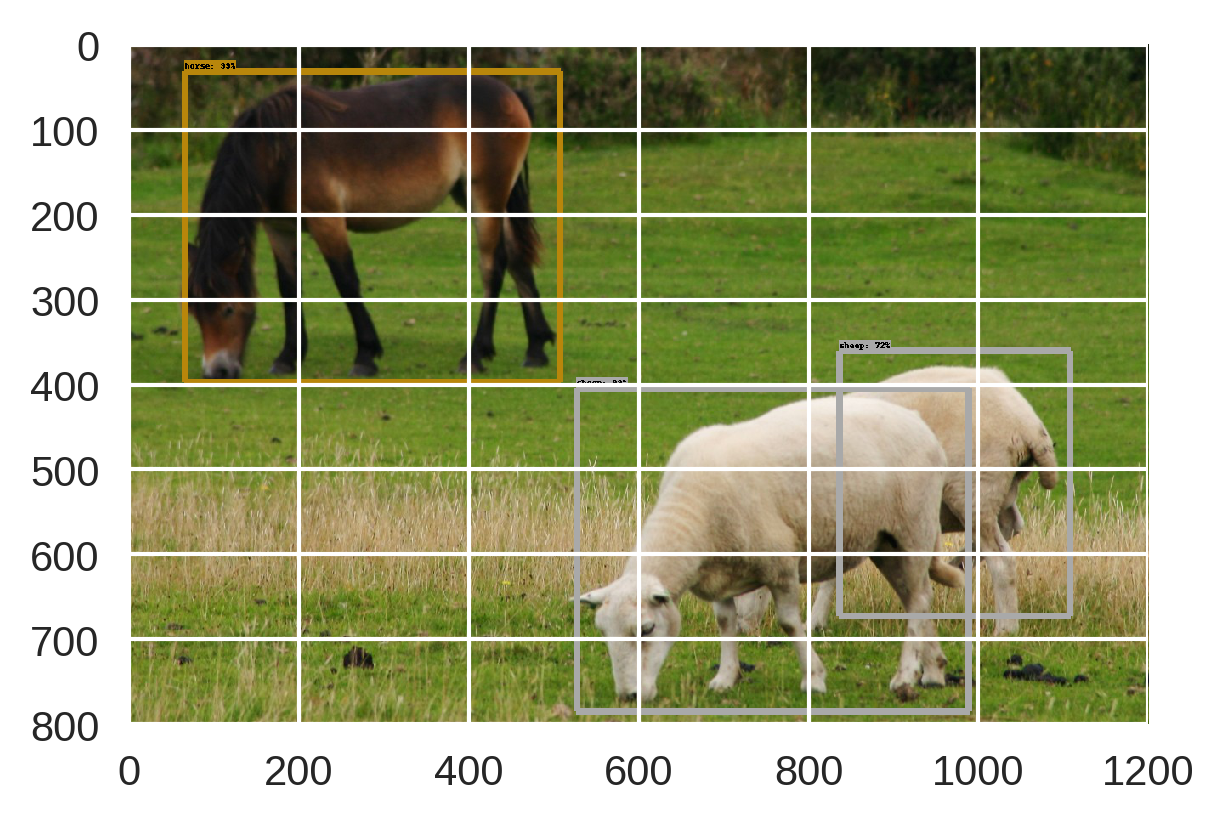

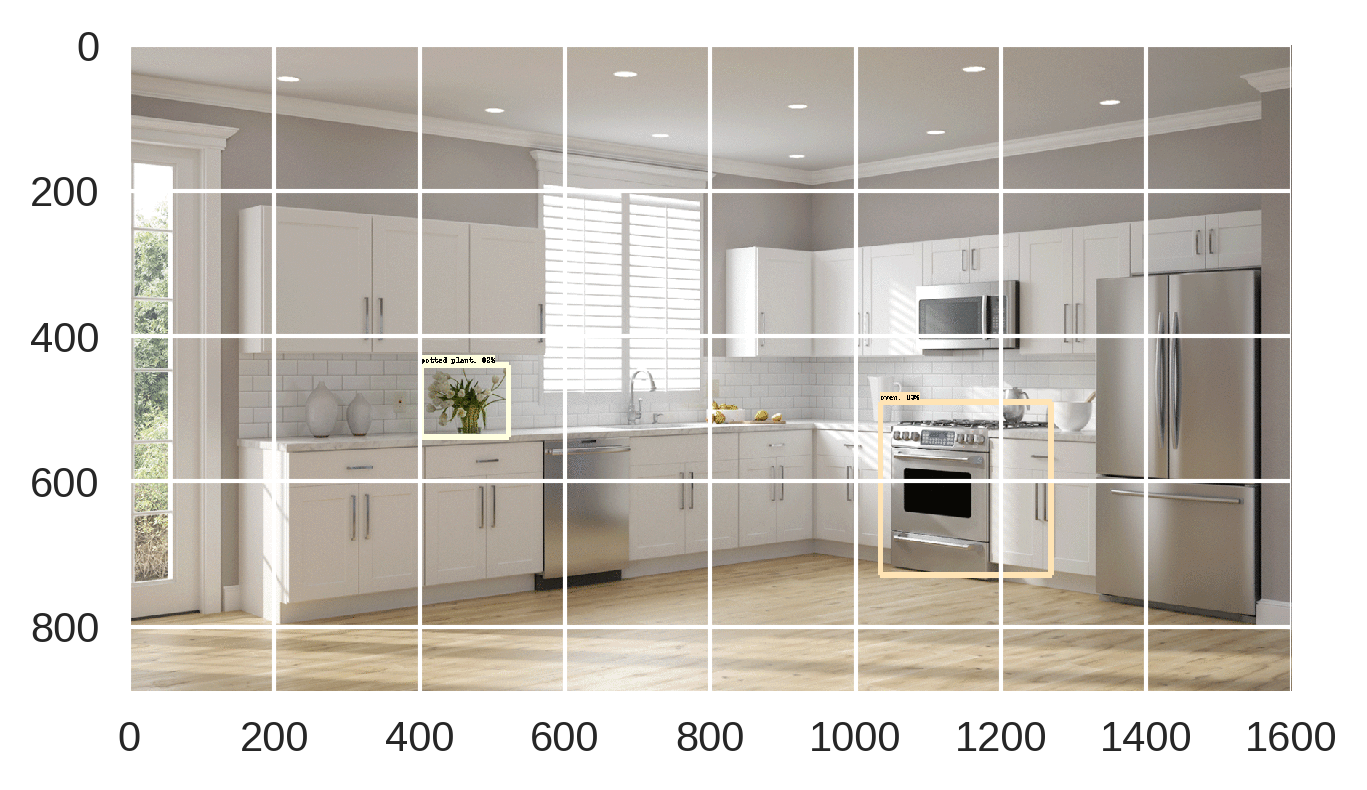

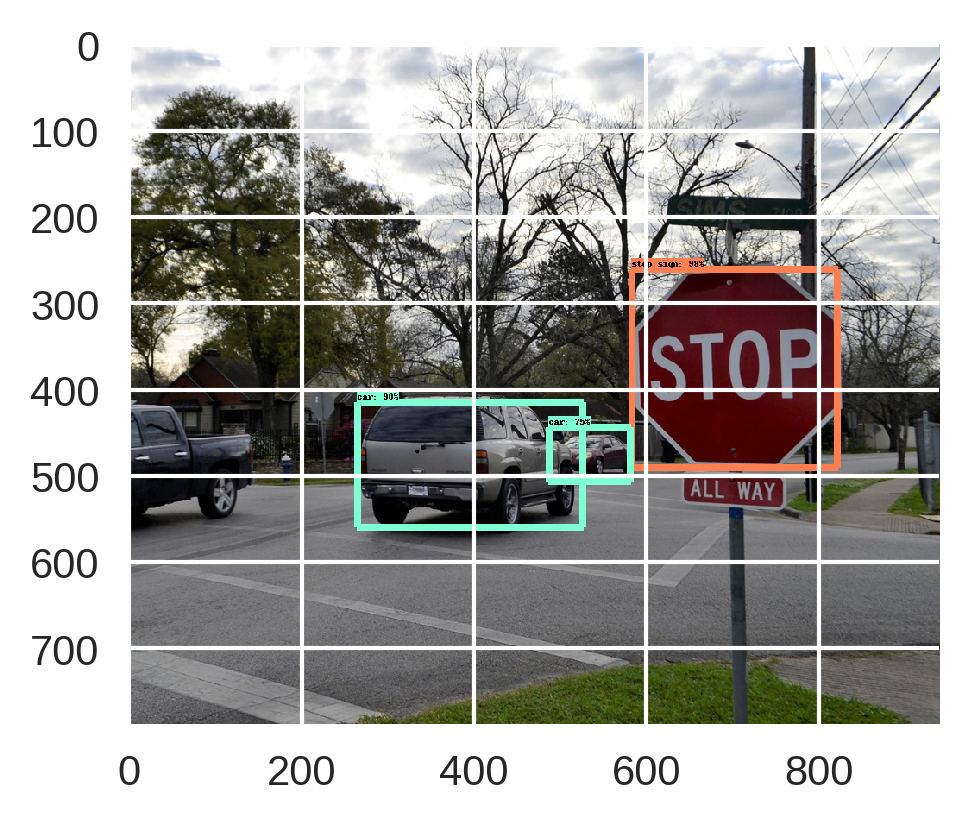

In [20]:
%matplotlib inline
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  start = time.time()
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  end = time.time()
  print('Run Inference Graph Time ', image_path ,' :',  (end - start))
  
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8,
      min_score_thresh=0.70)
  matplotlib.rcParams['figure.dpi']= 300 #raises the resolution of the test images with printed labels/boxes that are stored in object_detection/testing/output
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.savefig('/content/output/' + (os.path.splitext(os.path.basename(image_path))[0]) + '.png' , dpi=300 )